**Завдання 1**. Робота з набором файлів.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageOps
from IPython.display import display, HTML
from io import BytesIO
import base64
import os

In [10]:
def read_images(path: str, formats):
    files = glob.glob(path)
    
    images = [file for file in files if file.lower().endswith(formats)]
    
    return images

In [11]:
def get_thumbnail(path, size=(150, 150)):
    i = Image.open(path)
    i.thumbnail(size, Image.LANCZOS)
    
    if i.mode == 'P' or i.mode == 'RGBA':
        i = i.convert('RGBA')
        background = Image.new('RGB', i.size, (255, 255, 255))
        background.paste(i, mask=i.split()[3])
        i = background
    elif i.mode != 'RGB':
        i = i.convert('RGB')
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [12]:
def to_dataframe(path, formats):
    images = read_images(path, formats)
    
    labels = ['name', 'color model', 'format', 'channels', 'size', 'width', 'height', 'full path', 'image']
    frame = pd.DataFrame(columns=labels)
    
    for image_path in images:
        try:
            with Image.open(image_path) as img:
                file_size_mb = os.path.getsize(image_path) / (1024 * 1024)  
                frame.loc[len(frame)] = {
                    'name': image_path.split("/")[-1],
                    'color model': img.mode,
                    'format': img.format,
                    'channels': len(img.getbands()),
                    'size': round(file_size_mb, 2),
                    'width': img.width,
                    'height': img.height,
                    'full path': image_path,
                    'image': get_thumbnail(image_path)
                }
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    return frame
    

,name,color model,format,channels,size,width,height,full path,image
0,cat_PNG50486.png,P,PNG,1,0.42,1490,1520,images/cat_PNG50486.png,
1,Beautiful-Cat.jpg,RGB,JPEG,3,0.74,1280,800,images/Beautiful-Cat.jpg,
2,Cats.bmp,RGB,BMP,3,0.68,590,405,images/Cats.bmp,
3,sitting-cat.png,RGBA,PNG,4,3.08,2512,1933,images/sitting-cat.png,
4,a-cat.png,RGB,PNG,3,1.19,1200,600,images/a-cat.png,
5,dog-451643.webp,RGB,WEBP,3,0.21,2000,1200,images/dog-451643.webp,
6,cat_PNG50498.png,P,PNG,1,0.55,1720,1720,images/cat_PNG50498.png,
7,cats_gifs_25.gif,P,GIF,1,0.98,400,300,images/cats_gifs_25.gif,
8,kadinsky-cat.jpg,RGB,JPEG,3,0.19,900,599,images/kadinsky-cat.jpg,
9,cat1.jpg,RGB,JPEG,3,0.03,600,602,images/cat1.jpg,

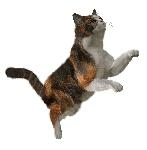
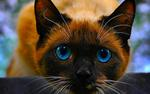
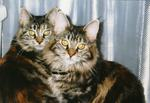
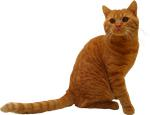
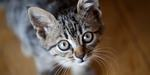
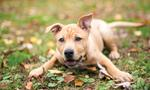
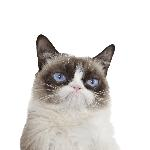
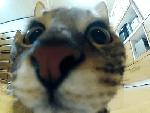
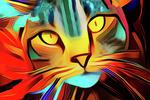
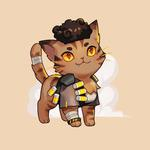
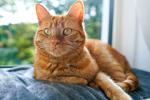
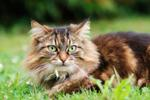
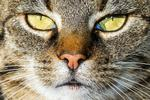
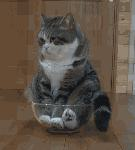
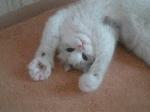

In [13]:
formats = ('.webp', '.bmp', '.png', '.gif', '.jpg')

images = to_dataframe('images/*', formats)
display(HTML(images.to_html(formatters={'image': image_formatter}, escape=False)))

**Завдання 2**. Створення постера.

In [14]:
def get_min_size(images):
    min_size = float('inf')
    for image_path in images:
        with Image.open(image_path) as img:
            min_size = min(min_size, img.size[0], img.size[1])
                
    return min_size
        
def get_image(i, img_size):
    if i.mode == 'P' or i.mode == 'RGBA':
        i = i.convert('RGBA')
        background = Image.new('RGB', img_size, (255, 255, 255))
        background.paste(i, mask=i.split()[3])
        i = background
    elif i.mode != 'RGB':
        i = i.convert('RGB')
    
    return i

def get_resized_image(img, size):
    return ImageOps.fit(img, (size, size), method=Image.LANCZOS, centering=(0.5, 0.5))

In [28]:
def merge(images, cols, rows):
    img_size = images[0].size[0]
    
    poster_width = cols * img_size
    poster_height = rows * img_size
    
    poster = Image.new("RGBA", (poster_width, poster_height))
    
    for index, img in enumerate(images):
        col = index % cols
        row = index // cols
        x = col * img_size
        y = row * img_size
        poster.paste(img, (x, y))
        
    return poster
    
def apply_filter(image, weights):
    if image.mode == "P":
        image = image.convert("RGBA")
    
    if image.mode == "RGBA":
        r, g, b, a = image.split()
    else:
        image = image.convert("RGB")
        r, g, b = image.split()
        a = None

    r = r.point(lambda v: min(255, v * weights[0]))
    g = g.point(lambda v: min(255, v * weights[1]))
    b = b.point(lambda v: min(255, v * weights[2]))
    
    if a:
        filtered_image = Image.merge("RGBA", (r, g, b, a))
    else:
        filtered_image = Image.merge("RGB", (r, g, b))
    
    return filtered_image

def choose_filter(option):
    #              red       blue     yellow      purple    light blue
    weights = [(1, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 1), (0, 1.2, 1.2)]
    
    return weights[option]

In [16]:
def to_poster(path, name, col, row, formats):
    all_images = read_images(path, formats)
    
    n = col * row
    x = 0
    y = len(all_images)
    
    numbers = np.random.randint(x, y, n)
    
    images = [all_images[i] for i in numbers]

    min_size = get_min_size(images)
    
    data = pd.DataFrame(columns=['image'])
    for image_path in images:
        with Image.open(image_path) as img:
            filter_option = np.random.randint(0, 5)
            color_filter = choose_filter(filter_option)
            
            data.loc[len(data)] = apply_filter(get_resized_image(img, min_size), color_filter)
    
    poster = merge(data['image'], col, row)
    poster.show()
    poster.save(name)

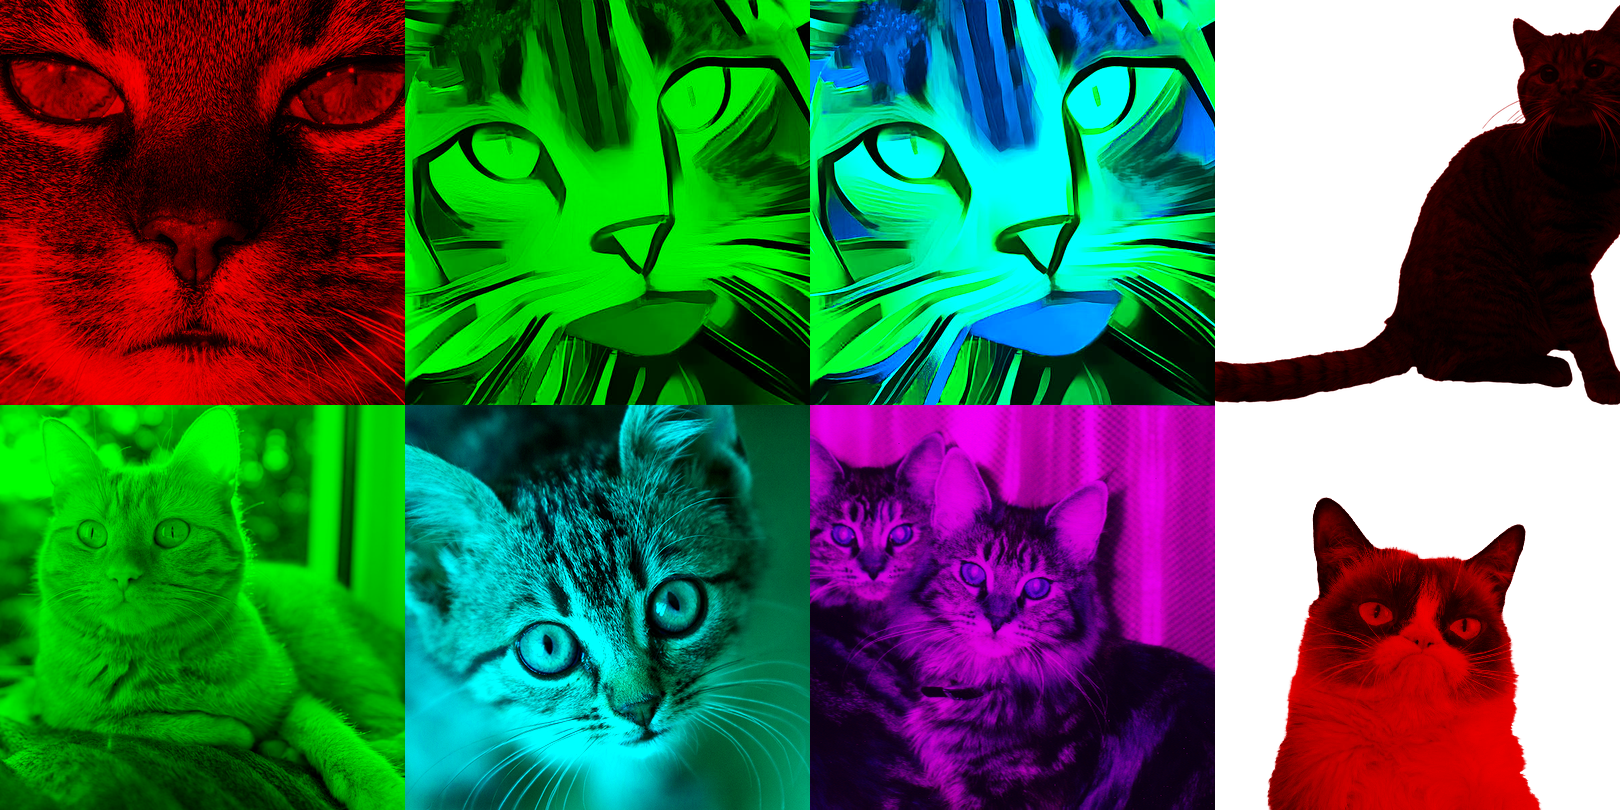

In [30]:
formats = ('.webp', '.bmp', '.png', '.gif', '.jpg')

to_poster('images/*', '2.png', 4, 2, formats)